In [ ]:
!pip install anvil-uplink

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jameskim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


correct [0.0, 0.7269, 0.5106, 0.5719]
incorrect [0.0, -0.6369, 0.5106, -0.4767]
correct [0.0, 0.7269, 0.5106, 0.5719]
incorrect [0.0, -0.6369, 0.5106, -0.4767]


KeyboardInterrupt: 

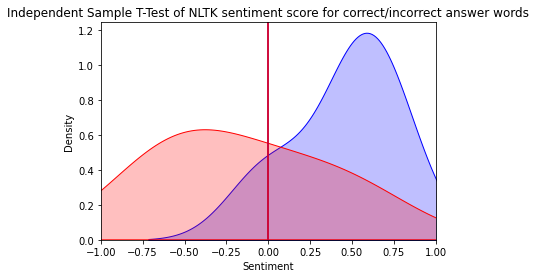

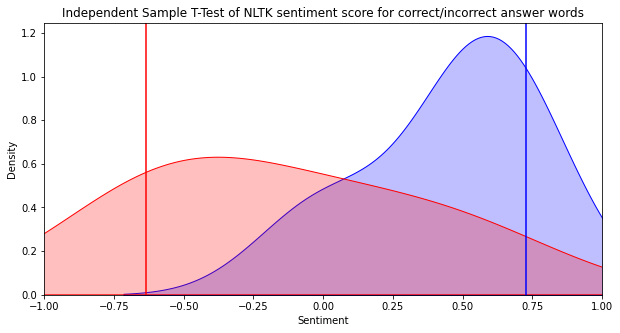

In [3]:

## RUN THIS CODE ON SOME OTHER BACKEND

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

import anvil.tables as tables
import anvil.tables.query as q
from anvil.tables import app_tables
import anvil.mpl_util
# import anvil.server
# # anvil.server.connect("7C3ZTSWMOZWVEMUNZ4XRVRIL-ZQVLD5KBAQVRV3UN")
import anvil.server
import requests
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
# import texthero
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import random

import json
from scipy import stats
import nltk
import collections
import random
import pickle

LANG = 'en'
APIKEY = 'FhyjBT0X3m0EmkQ' #replace with API key
APIURL = 'https://sentic.net/api/' + LANG + '/' + APIKEY + '.py?text=' 

THRESHOLD = 330
YRANGE = 100
EMOTIONS_LEVEL = {
    'ecstasy': 0, 'bliss': 0, 'delight': 0, 'enthusiasm': 0,
    'joy': 1, 'calmness': 1, 'pleasantness': 1, 'eagerness': 1, 
    'contentment': 2, 'serenity': 2, 'acceptance': 2, 'responsiveness': 2,
    'melancholy': 3, 'annoyance': 3, 'dislike': 3, 'anxiety': 3,
    'sadness': 4, 'anger': 4, 'disgust': 4, 'fear': 4,
    'grief': 5, 'rage': 5, 'loathing': 5, 'terror': 5,
    'No emotions detected': 3
}
introspection_emotions = ["ecstasy", "joy", "contentment", "melancholy", "sadness", "grief"]


anvil.server.connect("7C3ZTSWMOZWVEMUNZ4XRVRIL-ZQVLD5KBAQVRV3UN")


@anvil.server.callable
def add_feedback(vid, qid, q, c, i):

  # See if row exists
  row = app_tables.feedback.get(vid=vid, qid=qid)
  
  if(row != None):
    row.update(
      question = q,
      correct = c, 
      incorrect = i
    )
  else:
    app_tables.feedback.add_row(
      vid = vid,
      qid = qid, 
      question = q,
      correct = c, 
      incorrect = i
    )
  compute_sentiment(vid, qid, q, c, i)
  compute_emotion(vid, qid, q, c, i)
  
def compute_sentiment(vid, qid, q, c, i):
  qscore = sia.polarity_scores(q)['compound']
  cscore = sia.polarity_scores(c)['compound']
  iscore = sia.polarity_scores(i)['compound']

  row = app_tables.sentiment.get(vid=vid, qid=qid)
  
  if(row != None):
    row.update(
      question = qscore,
      correct = cscore, 
      incorrect = iscore
    )
  else:
    app_tables.sentiment.add_row(
      vid = vid,
      qid = qid, 
      question = qscore,
      correct = cscore,
      incorrect = iscore
    )

def compute_emotion(vid, qid, q, a, i):
    for c in [';', '&', '#', '{', '}']: q = q.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: a = a.replace(c, ':')
    for c in [';', '&', '#', '{', '}']: i = i.replace(c, ':')
    response = str(requests.get(APIURL + q).text)
    emotions = response[0:-1].split(", ")
    qemotion = emotions[0]
    response = str(requests.get(APIURL + a).text)
    emotions = response[0:-1].split(", ")
    aemotion = emotions[0]
    response = str(requests.get(APIURL + i).text)
    emotions = response[0:-1].split(", ")
    iemotion = emotions[0]

    row = app_tables.emotion.get(vid=vid, qid=qid)
    
    if(row != None):
        row.update(
        question = qemotion,
        correct = aemotion, 
        incorrect = iemotion
        )
    else:
        app_tables.emotion.add_row(
        vid = vid,
        qid = qid, 
        question = qemotion,
        correct = aemotion,
        incorrect = iemotion
        )
  
@anvil.server.callable
def get_sentiment_graph(vid=None, qid=None):
  plt.clf()
  x = [row["correct"] for row in app_tables.sentiment.search()]
  y = [row['incorrect'] for row in app_tables.sentiment.search()]
  print("correct", x)
  print("incorrect", y)
  sns.kdeplot(x, shade=True, color='blue', common_norm=True)
  sns.kdeplot(y, shade=True, color='red', common_norm=True)
  plt.title("Independent Sample T-Test of NLTK sentiment score for correct/incorrect answer words")
  plt.xlim((-1,1))
  plt.xlabel("Sentiment")

  row = app_tables.sentiment.get(vid=vid, qid=qid)
  if(row != None):
    plt.axvline(x = row["correct"], color = 'b', label = 'axvline - full height')
    plt.axvline(x = row["incorrect"], color = 'r', label = 'axvline - full height')
  
  return anvil.mpl_util.plot_image()

@anvil.server.callable
def get_emotion_graph(vid=None, qid=None):
    a_counts = [0, 0, 0, 0, 0, 0]
    i_counts = [0, 0, 0, 0, 0, 0]
    for row in app_tables.emotion.search():
        a_emo = row["correct"]
        a_level = EMOTIONS_LEVEL[a_emo]
        a_counts[a_level] += 1
        i_emo = row["incorrect"]
        i_level = EMOTIONS_LEVEL[i_emo]
        i_counts[i_level] += 1

    x_axis = np.arange(6)
    fig = plt.figure(figsize = (10, 5))
    plt.bar(x_axis -0.2, a_counts, width=0.4, label = 'correct')
    plt.bar(x_axis +0.2, i_counts, width=0.4, label = 'incorrect')
    plt.xticks(x_axis, introspection_emotions, rotation="vertical")
    plt.legend()
        
    plt.xlabel("Emotion Intensity")
    plt.ylabel("Count")
    plt.title("Emotion Detection Counts by Intensity")
    return anvil.mpl_util.plot_image()

@anvil.server.callable
def get_saved(vid,qid):
  row = app_tables.feedback.get(vid=vid, qid=qid)
  return row

# @anvil.server.callable
# def get_video(vid):
#     return app_tables.videos.get(vid=vid)

# @anvil.server.callable
# def add_video(vid, yid):
#     app_tables.videos.add_row(
#         vid=vid, youtubeID=yid
#     )

anvil.server.wait_forever()

In [1]:
# Emotion Constants by Level and Category
level0 = ["ecstasy", "bliss", "delight", "enthusiasm"]
level1 = ["joy", "calmness", "pleasantness", "eagerness"]
level2 = ["contentment", "serenity", "acceptance", "responsiveness"]
level3 = ["melancholy", "annoyance", "dislike", "anxiety"]
level4 = ["sadness", "anger", "disgust", "fear"]
level5 = ["grief", "rage", "loathing", "terror"]
introspection_emotions = ["ecstasy", "joy", "contentment", "melancholy", "sadness", "grief"]
temper_emotions = ["bliss", "calmness", "serenity", "annoyance", "anger", "rage"]
attitude_emotions = ["delight", "pleasantness", "acceptance", "dislike", "disgust", "loathing"]
sensitivity_emotions = ["enthusiasm", "eagerness", "responsiveness", "anxiety", "fear", "terror"]

EMOTIONS_BY_LEVEL = {
    0: ["ecstasy", "bliss", "delight", "enthusiasm"], 
    1: ["joy", "calmness", "pleasantness", "eagerness"],
    2: ["contentment", "serenity", "acceptance", "responsiveness"],
    3: ["melancholy", "annoyance", "dislike", "anxiety"],
    4: ["sadness", "anger", "disgust", "fear"],
    5: ["grief", "rage", "loathing", "terror"]
}
EMOTIONS_LEVEL = {
    'ecstasy': 0, 'bliss': 0, 'delight': 0, 'enthusiasm': 0,
    'joy': 1, 'calmness': 1, 'pleasantness': 1, 'eagerness': 1, 
    'contentment': 2, 'serenity': 2, 'acceptance': 2, 'responsiveness': 2,
    'melancholy': 3, 'annoyance': 3, 'dislike': 3, 'anxiety': 3,
    'sadness': 4, 'anger': 4, 'disgust': 4, 'fear': 4,
    'grief': 5, 'rage': 5, 'loathing': 5, 'terror': 5,
    'No emotions detected': 2.5
}
CATEGORIES = ["introspection", "temper", "attitude", "sensitivity"]
EMOTIONS_CAT = {
    "introspection" : ["ecstasy", "joy", "contentment", "melancholy", "sadness", "grief"],
    "temper" : ["bliss", "calmness", "serenity", "annoyance", "anger", "rage"],
    "attitude" : ["delight", "pleasantness", "acceptance", "dislike", "disgust", "loathing"],
    "sensitivity" : ["enthusiasm", "eagerness", "responsiveness", "anxiety", "fear", "terror"]
}

In [ ]:
## RUN THIS CODE ON SOME OTHER BACKEND

import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

import anvil.tables as tables
import anvil.tables.query as q
from anvil.tables import app_tables
import anvil.server
anvil.server.connect("7C3ZTSWMOZWVEMUNZ4XRVRIL-ZQVLD5KBAQVRV3UN")

@anvil.server.callable
def add_feedback(a, b, c):
  app_tables.feedback.add_row(
    question = a,
    correct = b, 
    incorrect = c
  )
  compute_sentiment(a, b, c)
  
def compute_sentiment(q, c, i):
  qscore = sia.polarity_scores(q)['compound']
  cscore = sia.polarity_scores(c)['compound']
  iscore = sia.polarity_scores(i)['compound']
  app_tables.sentiment.add_row(
    question = qscore,
    correct = cscore,
    incorrect = iscore
  )
  
@anvil.server.callable
def get_feedback():
  x = [row["correct"] for row in app_tables.sentiment.search()]
  y = [row['incorrect'] for row in app_tables.sentiment.search()]
  sns.kdeplot(x, shade=True, color='blue', common_norm=True)
  sns.kdeplot(y, shade=True, color='red', common_norm=True)
  plt.title("Independent Sample T-Test of NLTK sentiment score for correct/incorrect answer words")
  plt.xlim((-1,1))
  return anvil.mpl_util.plot_image()
  

In [41]:
from PIL import Image, ImageDraw, ImageFont

import numpy as np
import json

In [102]:
# Given array of words and array of attention values (should be same length),
# create gradient image according to corresponding attention values
def text2img(texts, attentions):
    diff = max(attentions) - min(attentions)
    ranges = [255, 190, 125, 60, 0, 0]
    grads = [ranges[int((attentions[i] - min(attentions)) * 5 / diff)] for i in range(len(attentions))]
    total_len = 6 + 6 * len(texts)
    for i in range(len(texts)): total_len += len(texts[i]) * 6
    img = Image.new('RGB', (total_len, 15), (255, 255, 255))
    d = ImageDraw.Draw(img)
    index = 3
    for i in range(len(texts)):
        text, grad = texts[i], grads[i]
        nextindex = index + len(text) * 6 
        d.rectangle([(index-3, 0), (nextindex+3, 15)], fill=(0, 0, grad))
        d.text((index, 0), text, fill=(255, 255, 255))
        index = nextindex + 6
    return img

In [58]:
# Given question, correct, and incorrect answer word arrays and their attention arrays,
# output 3 gradient images
def generateAttentionImgs(q, a, i, qval, aval, ival):
    qimg = text2img(q, qval)
    aimg = text2img(a, aval)
    iimg = text2img(i, ival)
    return qimg, aimg, iimg

In [103]:
# test
text2img(["Hello", "this", "is", "test"], [0.1, 0.4, 0.7, 0.9])

In [68]:
# Code to open json file and for each row (q, a, i, qval, aval, ival), generate attention images
f = open('new.json')
data = json.load(f)
for row in data:
    q, a, i, qval, aval, ival = row["q"], row["a"], row["i"], row["q_vals"], row["a_vals"], row["i_vals"]
    qimg, aimg, iimg = generateAttentionImg(q, a, i, qval, aval, ival)
    
    